In [70]:
import os
import sys
import glob
import math

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

# for rugarch
import rpy2
import os
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri

base = importr('base')
rugarch = importr("rugarch", lib_loc = "C:/Users/suare/OneDrive/Documents/asuare/R/win-library/3.6")

%matplotlib inline

In [71]:
 def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

def _get_best_model(TS):
    # TODO: Nada de rolling window aqui. quiza habria que hacerla en algun lado. evluar la idea de: https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(1) # [0] # we'll use arma-garch, so not d (= 0)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

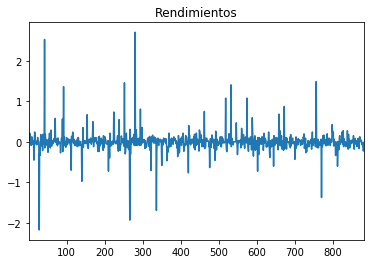

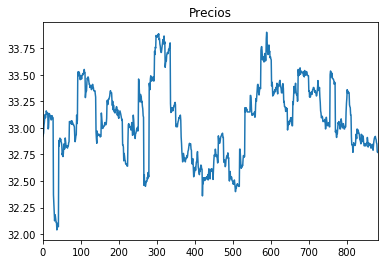

In [72]:
# regex = '20170717'
# fpattern = f'C:\\Users\\suare\\MEGA\\PhD\\1 Code and data\\data\\raw\\quantquote\\one_second_level\\242321_csv\\{regex}\\spy.csv'

multiplier = -5

# path, multiplier = '..\\data\\aapl\\APPLE_[2018-08-01_to_2018-09-11]_5min.csv', multiplier
# path, multiplier = '..\\data\\efts\\5min-level\\DOWJONES\\DOWJONES_[2015-08-01_to_2015-08-31]_market_hours.csv', multiplier
# path, multiplier = '..\\data\\btc\\BITCOIN_[2019-07-01_to_2019-07-15]_5min.csv', multiplier
# path, multiplier = '..\\data\\xrp\\RIPPLE_[2019-06-01_to_2019-07-01]_5min.csv', multiplier
# path, multiplier = '..\\data\\efts\\30min-level\\IBEX\\IBEX_[2017-10-01_to_2017-31-12]_market_hours.csv', multiplier
# path, multiplier = '..\\data\\xrp\\RIPPLE_[2019-07-01_to_2019-08-01]_5min.csv', multiplier
path, multiplier = '..\\data\\efts\\30min-level\\IBEX\\IBEX_[2017-10-01_to_2017-31-12]_market_hours.csv', multiplier

fpattern = path
# colnames=['Time','Open','High','Low','Close','Volume','Suspicious']
sp500 = pd.read_csv(fpattern, sep=';')
# sp500 = pd.concat(list(pd.read_csv(f, names=colnames) for f in glob.glob(fpattern)), ignore_index=True)
# regex='DOWJONES_(2015-01-01_to_2015-12-31)_indicators.csv.gz'
# path=os.sep.join(['G:','My Drive','PhD_Andres','Datos','quantquote','processed_data','2_result','minutes','15min-level','DOWJONES'])
# fpattern = os.sep.join([path,regex])
# sp500 = pd.read_csv(fpattern, compression='gzip')

returns = 100 * sp500['close'].pct_change().dropna()   # pct_change es para rendimientos
returns.plot(title="Rendimientos")
plt.show()
prices = sp500['close'].dropna() 
prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
plt.show()
data =  prices

In [73]:
sp500.head()

datetime    open   high      low   close    volume  gap  \
0  2017-10-02 09:30:00  32.870  32.92  32.8700  32.920  201622.0  0.0   
1  2017-10-02 10:00:00  32.920  32.97  32.8900  32.935  242965.0  0.0   
2  2017-10-02 10:30:00  32.935  32.98  32.9234  32.950  312518.0  0.0   
3  2017-10-02 11:00:00  32.960  33.02  32.9600  33.020  133301.0  0.0   
4  2017-10-02 11:30:00  33.010  33.09  33.0000  33.050  311079.0  0.0   

    timestamp  
0  1506936600  
1  1506938400  
2  1506940200  
3  1506942000  
4  1506943800

In [74]:
mode = 'returns'

# train the standardization
df = data.to_frame()
min_max_scaler = MinMaxScaler()
min_max_scaler = min_max_scaler.fit(df)
print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 

if mode=='returns':    
    TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True)#.dropna().reset_index(drop=True)
else:     
    # standardization the dataset
    TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)                                                                  


Min: 32.04, Max: 33.9


In [75]:
# res_tup = (4, 0, 3) # _get_best_model(TS)  
# res_tup = (8, 0, 8)
# res_tup = (4, 0, 5)
# res_tup = (2, 0, 5)
# res_tup = (4, 0, 5)
# res_tup = (8, 0, 6)
# res_tup = (9, 0, 10)
# RES_TUP = (7, 0, 8)
res_tup = (9, 0, 9)

# 8, 0, 8, 2, 3
order = res_tup[1]
model = res_tup[2]
order

0

In [76]:
tsplot(model.resid, lags=30)

AttributeError: 'int' object has no attribute 'resid'

In [77]:
tsplot(model.resid**2, lags=30)

AttributeError: 'int' object has no attribute 'resid'

In [78]:
# Now we can fit the arch model using the best fit arima model parameters
p_, q_ = 9, 9 # 7, 8 # 9, 10 # 8, 6 # 4, 5 # 2, 5 # 4, 5  # 8, 8 # 4, 3 # order[0], order[2]
# o_ = order[1]
g_p, g_q = 3, 1 # 2, 1 # 1, 3 # 2, 4 # 1, 1 # 1, 4 #  1, 5  # 2, 3 # 1, 1

# Initialize R GARCH model
garch_spec = rugarch.ugarchspec(
    #mean_model=robjects.r(f'list(arimaOrder=c({p_},{o_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
    variance_model=robjects.r(f'list(garchOrder=c({g_p},{g_q}))'),    
    distribution_model='sged')  # 'std'

#If you have looked at the package vignette, you would have seen that package rugarch estimates ARFIMA(p,d,q) 
# model with 0<d<1. So it is not possible to set the integration order higher than one. 
# If you want to keep the value d fixed set fixed.pars=list(arfima=d). 
# For that naturally you need to set arfima=TRUE in the argument mean.model

print(garch_spec)



*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*



Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(3,1)

Variance Targeting	: FALSE 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(9,0,9)

Include Mean		: TRUE 

GARCH-in-Mean		: FALSE 



Conditional Distribution

------------------------------------

Distribution	:  sged 

Includes Skew	:  TRUE 

Includes Shape	:  TRUE 

Includes Lambda	:  FALSE 





In [79]:
# Used to convert training set to R list for model input
numpy2ri.activate()
forecast_horizon = 20

# Train R GARCH model on returns as %
garch_fitted = rugarch.ugarchfit(
    spec=garch_spec,
    data=np.array(TS),
    out_sample=forecast_horizon
)
numpy2ri.deactivate()

In [80]:
print(garch_fitted)



*---------------------------------*

*          GARCH Model Fit        *

*---------------------------------*



Conditional Variance Dynamics 	

-----------------------------------

GARCH Model	: sGARCH(3,1)

Mean Model	: ARFIMA(9,0,9)

Distribution	: sged 



Optimal Parameters

------------------------------------

        Estimate  Std. Error    t value Pr(>|t|)

mu     -0.000058    0.000002  -36.33164  0.00000

ar1    -0.296702    0.003234  -91.73168  0.00000

ar2     0.179150    0.001989   90.08392  0.00000

ar3     0.681255    0.004523  150.63148  0.00000

ar4    -0.169985    0.001560 -108.98063  0.00000

ar5    -0.597843    0.008804  -67.90360  0.00000

ar6    -0.343434    0.004953  -69.34505  0.00000

ar7     0.212549    0.001572  135.21516  0.00000

ar8     0.379661    0.003948   96.16342  0.00000

ar9     0.046668    0.000861   54.19281  0.00000

ma1     0.252623    0.002818   89.63778  0.00000

ma2    -0.120370    0.001747  -68.91081  0.00000

ma3    -0.700443    0.004287

In [81]:
print('Showing ARMA-GARCH coefficients:')
print(garch_fitted.slots['fit'].rx2('coef'))

Showing ARMA-GARCH coefficients:
           mu           ar1           ar2           ar3           ar4 

-5.845480e-05 -2.967022e-01  1.791503e-01  6.812555e-01 -1.699853e-01 

          ar5           ar6           ar7           ar8           ar9 

-5.978432e-01 -3.434337e-01  2.125485e-01  3.796607e-01  4.666821e-02 

          ma1           ma2           ma3           ma4           ma5 

 2.526234e-01 -1.203701e-01 -7.004432e-01  1.804276e-01  5.675354e-01 

          ma6           ma7           ma8           ma9         omega 

 3.404998e-01 -2.112518e-01 -3.841255e-01 -5.843154e-02  7.026061e-08 

       alpha1        alpha2        alpha3         beta1          skew 

 8.343221e-03  7.396191e-03  6.910078e-03  9.672303e-01  9.755132e-01 

        shape 

 5.001452e-01 



In [82]:
# Model's fitted standard deviation values
fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

# Forecast 
garch_forecast = rugarch.ugarchforecast(
    garch_fitted,
    n_ahead=6,
    n_roll=0, #forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [83]:
forecast

array([ 4.84829808e-05, -7.58527491e-05, -4.39769837e-05, -5.60315650e-05,
       -8.62595803e-05, -3.68653577e-05])

In [ ]:
# TESTING STUFF 18-09-2019

# print(garch_fitted.slots['fit'].rx2('coef'))
# rugarch.setfixed=(rugarch.getspec(garch_fitted), garch_fitted.slots['fit'].rx2('coef'))

# # Forecast 
# garch_f1 = rugarch.ugarchforecast(
#     spec=rugarch.getspec(garch_fitted),
#     n_ahead=1,
#     n_roll=forecast_horizon - 1
# )

# # Model's forecasted standard deviation values
# forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
# forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [ ]:
## http://www.unstarched.net/r-examples/rugarch/a-short-introduction-to-the-rugarch-package/
# numpy2ri.activate()
# filt1 = rugarch.ugarchfilter(spec=rugarch.getspec(garch_fitted), data=np.array(TS), n_old = len(TS))
# numpy2ri.deactivate()

# filt1 = ugarchfilter(spec, sp500ret[1:1200, ], n.old = 1000)
# filt2 = ugarchfilter(spec, sp500ret[1001:1200, ])
# then forecast


In [48]:
# Model's fitted standard deviation values
fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

# Forecast 
garch_forecast = rugarch.ugarchforecast(
    garch_fitted,
    n_ahead=1,
    n_roll=forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [49]:
np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()

array([0.0026185 , 0.0026185 , 0.0026185 , 0.0026185 , 0.0026185 ,
       0.0026185 , 0.0026185 , 0.0026185 , 0.0026185 , 0.00259226,
       0.00256825, 0.00254351, 0.00251874, 0.00249214, 0.00246599,
       0.00247446, 0.00247853, 0.00249347, 0.00248265, 0.00247092,
       0.00244856, 0.00242302, 0.00239888, 0.00237528, 0.0023522 ,
       0.00233133, 0.00231099, 0.00229089, 0.00226914, 0.0030179 ,
       0.00354813, 0.00396678, 0.00393131, 0.0038876 , 0.00384108,
       0.00379323, 0.0037436 , 0.00369465, 0.00365221, 0.00361347,
       0.00357459, 0.00353001, 0.00348242, 0.0041196 , 0.00458982,
       0.00497259, 0.00489946, 0.004828  , 0.00475766, 0.00468708,
       0.0046173 , 0.00454928, 0.00448612, 0.00442389, 0.00436247,
       0.00429946, 0.00424107, 0.00418389, 0.00413056, 0.00407477,
       0.00403097, 0.00398497, 0.00394024, 0.0038862 , 0.00383227,
       0.00377858, 0.00372591, 0.00367457, 0.00362398, 0.00357515,
       0.0035271 , 0.00352107, 0.00350988, 0.00349654, 0.00344

In [84]:
tuple(garch_fitted.slotnames())

('fit', 'model')

In [85]:
import rpy2.robjects as robjects

get_infocrit = robjects.r('''function(fitted) {
                                return(infocriteria(fitted))
                             }''')

get_coef = robjects.r('''function(fitted) {
                                return(coef(fitted))
                             }''')


In [86]:
print(get_infocrit(garch_fitted))

                       

Akaike       -10.127559

Bayes         -9.984009

Shibata      -10.129309

Hannan-Quinn -10.072609



In [87]:
get_infocrit(garch_fitted)

R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x0000023B458F06C8 / R:0x0000023B5641C740>
[-10.127559, -9.984009, -10.129309, -10.072609]

In [88]:
tuple(garch_fitted.slots['fit'].names)

('hessian',
 'cvar',
 'var',
 'sigma',
 'condH',
 'z',
 'LLH',
 'log.likelihoods',
 'residuals',
 'coef',
 'robust.cvar',
 'A',
 'B',
 'scores',
 'se.coef',
 'tval',
 'matcoef',
 'robust.se.coef',
 'robust.tval',
 'robust.matcoef',
 'fitted.values',
 'convergence',
 'kappa',
 'persistence',
 'timer',
 'ipars',
 'solver')

In [89]:
print(garch_fitted.slots['fit'].rx2('coef'))  # this gives a vector of coefficients [mu, ar1, ar2, ar3, ar4, ma1, ma2, ma3, omega, alpha1, beta1. skw, shape]
coef = garch_fitted.slots['fit'].rx2('coef') 

           mu           ar1           ar2           ar3           ar4 

-5.845480e-05 -2.967022e-01  1.791503e-01  6.812555e-01 -1.699853e-01 

          ar5           ar6           ar7           ar8           ar9 

-5.978432e-01 -3.434337e-01  2.125485e-01  3.796607e-01  4.666821e-02 

          ma1           ma2           ma3           ma4           ma5 

 2.526234e-01 -1.203701e-01 -7.004432e-01  1.804276e-01  5.675354e-01 

          ma6           ma7           ma8           ma9         omega 

 3.404998e-01 -2.112518e-01 -3.841255e-01 -5.843154e-02  7.026061e-08 

       alpha1        alpha2        alpha3         beta1          skew 

 8.343221e-03  7.396191e-03  6.910078e-03  9.672303e-01  9.755132e-01 

        shape 

 5.001452e-01 



In [90]:
omega = coef[-5]
alpha = coef[-4]
beta = coef[-3]

In [91]:
alpha

0.006910078447587431

In [92]:
print(get_coef(garch_fitted))

           mu           ar1           ar2           ar3           ar4 

-5.845480e-05 -2.967022e-01  1.791503e-01  6.812555e-01 -1.699853e-01 

          ar5           ar6           ar7           ar8           ar9 

-5.978432e-01 -3.434337e-01  2.125485e-01  3.796607e-01  4.666821e-02 

          ma1           ma2           ma3           ma4           ma5 

 2.526234e-01 -1.203701e-01 -7.004432e-01  1.804276e-01  5.675354e-01 

          ma6           ma7           ma8           ma9         omega 

 3.404998e-01 -2.112518e-01 -3.841255e-01 -5.843154e-02  7.026061e-08 

       alpha1        alpha2        alpha3         beta1          skew 

 8.343221e-03  7.396191e-03  6.910078e-03  9.672303e-01  9.755132e-01 

        shape 

 5.001452e-01 



In [93]:
tuple(garch_fitted.slots['model'].names)

('modelinc',
 'modeldesc',
 'modeldata',
 'pars',
 'start.pars',
 'fixed.pars',
 'maxOrder',
 'pos.matrix',
 'fmodel',
 'pidx',
 'n.start')

In [94]:
rugarch.getspec(garch_fitted).slots

In [95]:
rugarch.ugarchspec()

R object with classes: ('uGARCHspec',) mapped to:
<RS4 - Python:0x0000023B458F01C8 / R:0x0000023B52E03A48>

In [96]:
print(rugarch.getspec(garch_fitted))



*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*



Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(3,1)

Variance Targeting	: FALSE 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(9,0,9)

Include Mean		: TRUE 

GARCH-in-Mean		: FALSE 



Conditional Distribution

------------------------------------

Distribution	:  sged 

Includes Skew	:  TRUE 

Includes Shape	:  TRUE 

Includes Lambda	:  FALSE 





In [63]:
# # Forecast 
# garch_forecast = rugarch.ugarchforecast(spec=garch_spec,
#     data=
#     n_ahead=1,
#     n_roll=forecast_horizon - 1
# )

# # Model's forecasted standard deviation values
# forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
# forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [64]:
garch_fitted.slots['fit'].rx2('coef')

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000023B45A58608 / R:0x0000023B45C00E98>
[-0.000058, -0.296702, 0.179150, 0.681255, ..., 0.006910, 0.967230, 0.975513, 0.500145]

In [65]:
rugarch.getspec(garch_fitted)

R object with classes: ('uGARCHspec',) mapped to:
<RS4 - Python:0x0000023B467C6408 / R:0x0000023B51EF7F50>

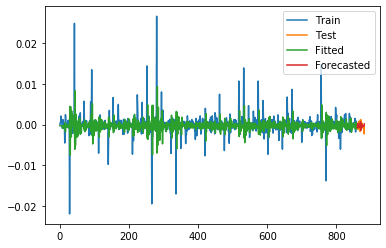

In [66]:
multiplier = 5

output = pd.DataFrame({
    'actual': list(np.array(TS)),
    'model': np.append(fitted*multiplier, forecast*multiplier),
})

plt.plot(output['actual'][:-forecast_horizon], label='Train')
plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
plt.plot(output['model'][:-forecast_horizon], label='Fitted')
plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
plt.legend()
plt.show()

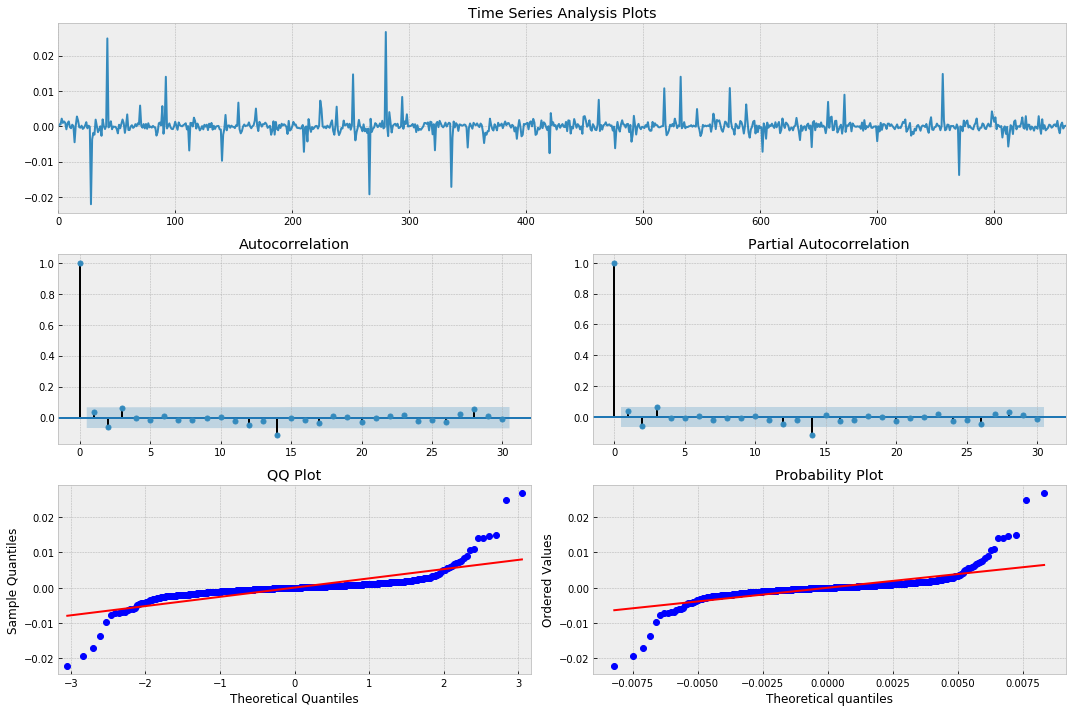

In [67]:
tsplot(minute_volatility_residuals, lags=30)

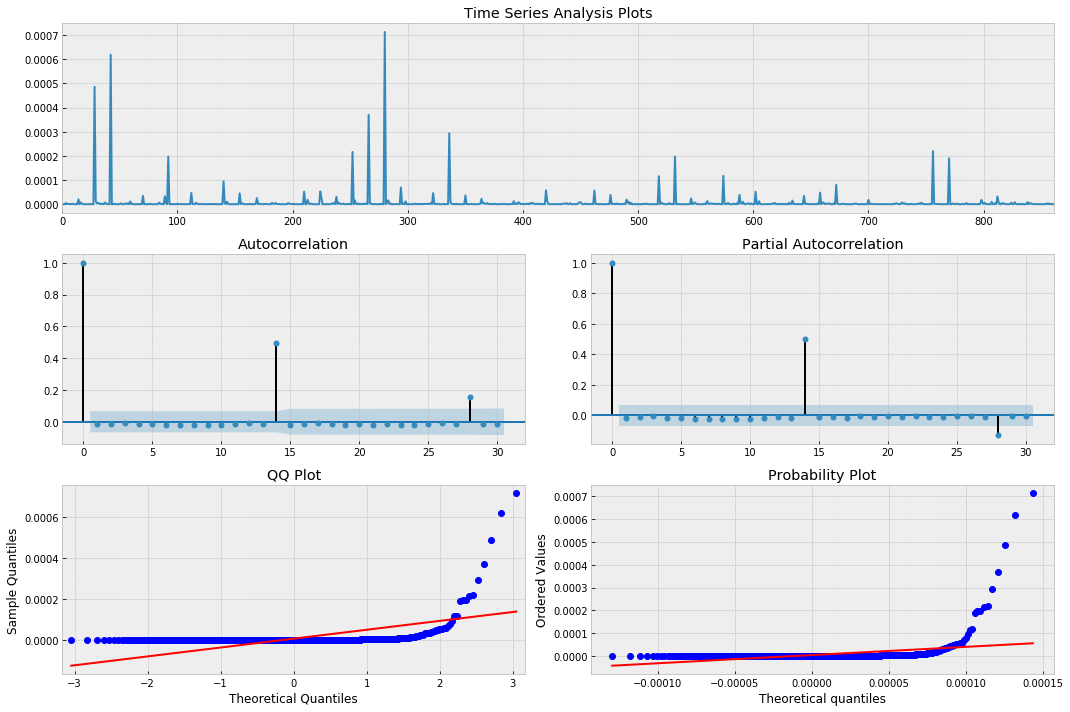

In [68]:
tsplot(minute_volatility_residuals**2, lags=30)

Close  ts_logr_na0  logr_na0  cuml_log  reconstructed_price_norm  \
0    32.9200     0.000000 -0.000058 -0.000058                  0.999942   
1    32.9350     0.000456 -0.000058 -0.000117                  0.999883   
2    32.9500     0.000455 -0.000058 -0.000175                  0.999825   
3    33.0200     0.002122 -0.000058 -0.000234                  0.999766   
4    33.0500     0.000908 -0.000058 -0.000292                  0.999708   
5    33.0940     0.001330 -0.000058 -0.000351                  0.999649   
6    33.1250     0.000936 -0.000058 -0.000409                  0.999591   
7    33.0950    -0.000906 -0.000058 -0.000468                  0.999532   
8    33.1200     0.000755 -0.000058 -0.000526                  0.999474   
9    33.1600     0.001207 -0.000187 -0.000713                  0.999287   
10   33.1500    -0.000302 -0.000058 -0.000771                  0.999230   
11   33.1300    -0.000604 -0.000062 -0.000833                  0.999168   
12   33.1400     0.000302 -0.000159 -0.000992                  0.999009   
13   33.1400     0.000000 -0.000078 -0.001070                  0.998931   
14   32.9900    -0.004537 -0.000031 -0.001101                  0.998899   
15   33.0000     0.000303  0.000091 -0.001010                  0.998990   
16   33.0800     0.002421 -0.000365 -0.001376                  0.998625   
17   33.1350     0.001661  0.000042 -0.001334                  0.998667   
18   33.1270    -0.000241  0.000015 -0.001318                  0.998683   
19   33.1100    -0.000513 -0.000131 -0.001450                  0.998552   
20   33.1150     0.000151 -0.000033 -0.001483                  0.998519   
21   33.0900    -0.000755 -0.000026 -0.001508                  0.998493   
22   33.0750    -0.000453 -0.000030 -0.001538                  0.998463   
23   33.0800     0.000151 -0.000090 -0.001628                  0.998373   
24   33.1153     0.001067 -0.000116 -0.001744                  0.998257   
25   33.0945    -0.000628 -0.000066 -0.001810                  0.998192   
26   33.1000     0.000166 -0.000016 -0.001826                  0.998176   
27   33.0900    -0.000302 -0.000195 -0.002021                  0.997981   
28   32.3700    -0.021999  0.000052 -0.001969                  0.998033   
29   32.2800    -0.002784  0.000900 -0.001069                  0.998932   
..       ...          ...       ...       ...                       ...   
832  32.9500     0.000000  0.000052 -0.050868                  0.950404   
833  32.9300    -0.000607 -0.000238 -0.051106                  0.950177   
834  32.8900    -0.001215  0.000011 -0.051095                  0.950188   
835  32.8850    -0.000152 -0.000093 -0.051188                  0.950100   
836  32.8700    -0.000456 -0.000204 -0.051393                  0.949906   
837  32.8500    -0.000609  0.000082 -0.051311                  0.949984   
838  32.9400     0.002736 -0.000139 -0.051449                  0.949852   
839  32.9300    -0.000304 -0.000169 -0.051618                  0.949691   
840  32.8700    -0.001824  0.000286 -0.051333                  0.949963   
841  32.9300     0.001824 -0.000177 -0.051510                  0.949795   
842  32.9000    -0.000911 -0.000195 -0.051704                  0.949610   
843  32.9200     0.000608  0.000290 -0.051414                  0.949885   
844  32.8700    -0.001520 -0.000379 -0.051793                  0.949525   
845  32.8465    -0.000715  0.000066 -0.051727                  0.949588   
846  32.8300    -0.000502 -0.000092 -0.051819                  0.949500   
847  32.8400     0.000305 -0.000177 -0.051996                  0.949332   
848  32.8500     0.000304  0.000012 -0.051984                  0.949344   
849  32.8350    -0.000457 -0.000067 -0.052051                  0.949280   
850  32.8300    -0.000152 -0.000038 -0.052089                  0.949244   
851  32.8464     0.000499  0.000039 -0.052050                  0.949282   
852  32.8600     0.000414 -0.000128 -0.052177                  0.949161   
853  32.8600     0.000000  0.000

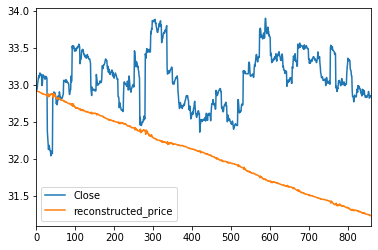

In [69]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
df

Close  ts_logr_na0  logr_na0  cuml_log  reconstructed_price_norm  \
0    32.9200     0.000000 -0.000058 -0.000058                  0.999942   
1    32.9350     0.000456 -0.000058 -0.000117                  0.999883   
2    32.9500     0.000455 -0.000058 -0.000175                  0.999825   
3    33.0200     0.002122 -0.000058 -0.000234                  0.999766   
4    33.0500     0.000908 -0.000058 -0.000292                  0.999708   
5    33.0940     0.001330 -0.000058 -0.000351                  0.999649   
6    33.1250     0.000936 -0.000058 -0.000409                  0.999591   
7    33.0950    -0.000906 -0.000058 -0.000468                  0.999532   
8    33.1200     0.000755 -0.000058 -0.000526                  0.999474   
9    33.1600     0.001207 -0.000187 -0.000713                  0.999287   
10   33.1500    -0.000302 -0.000058 -0.000771                  0.999230   
11   33.1300    -0.000604 -0.000062 -0.000833                  0.999168   
12   33.1400     0.000302 -0.000159 -0.000992                  0.999009   
13   33.1400     0.000000 -0.000078 -0.001070                  0.998931   
14   32.9900    -0.004537 -0.000031 -0.001101                  0.998899   
15   33.0000     0.000303  0.000091 -0.001010                  0.998990   
16   33.0800     0.002421 -0.000365 -0.001376                  0.998625   
17   33.1350     0.001661  0.000042 -0.001334                  0.998667   
18   33.1270    -0.000241  0.000015 -0.001318                  0.998683   
19   33.1100    -0.000513 -0.000131 -0.001450                  0.998552   
20   33.1150     0.000151 -0.000033 -0.001483                  0.998519   
21   33.0900    -0.000755 -0.000026 -0.001508                  0.998493   
22   33.0750    -0.000453 -0.000030 -0.001538                  0.998463   
23   33.0800     0.000151 -0.000090 -0.001628                  0.998373   
24   33.1153     0.001067 -0.000116 -0.001744                  0.998257   
25   33.0945    -0.000628 -0.000066 -0.001810                  0.998192   
26   33.1000     0.000166 -0.000016 -0.001826                  0.998176   
27   33.0900    -0.000302 -0.000195 -0.002021                  0.997981   
28   32.3700    -0.021999  0.000052 -0.001969                  0.998033   
29   32.2800    -0.002784  0.000900 -0.001069                  0.998932   
..       ...          ...       ...       ...                       ...   
832  32.9500     0.000000  0.000052 -0.050868                  0.950404   
833  32.9300    -0.000607 -0.000238 -0.051106                  0.950177   
834  32.8900    -0.001215  0.000011 -0.051095                  0.950188   
835  32.8850    -0.000152 -0.000093 -0.051188                  0.950100   
836  32.8700    -0.000456 -0.000204 -0.051393                  0.949906   
837  32.8500    -0.000609  0.000082 -0.051311                  0.949984   
838  32.9400     0.002736 -0.000139 -0.051449                  0.949852   
839  32.9300    -0.000304 -0.000169 -0.051618                  0.949691   
840  32.8700    -0.001824  0.000286 -0.051333                  0.949963   
841  32.9300     0.001824 -0.000177 -0.051510                  0.949795   
842  32.9000    -0.000911 -0.000195 -0.051704                  0.949610   
843  32.9200     0.000608  0.000290 -0.051414                  0.949885   
844  32.8700    -0.001520 -0.000379 -0.051793                  0.949525   
845  32.8465    -0.000715  0.000066 -0.051727                  0.949588   
846  32.8300    -0.000502 -0.000092 -0.051819                  0.949500   
847  32.8400     0.000305 -0.000177 -0.051996                  0.949332   
848  32.8500     0.000304  0.000012 -0.051984                  0.949344   
849  32.8350    -0.000457 -0.000067 -0.052051                  0.949280   
850  32.8300    -0.000152 -0.000038 -0.052089                  0.949244   
851  32.8464     0.000499  0.000039 -0.052050                  0.949282   
852  32.8600     0.000414 -0.000128 -0.052177                  0.949161   
853  32.8600     0.000000  0.000

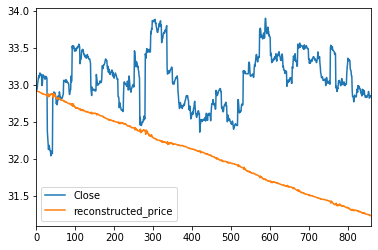

In [53]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted  # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(float)
df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
df

In [278]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * multiplier) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(int)
df

# making sure that the model adaps well
fitted_reconstructed = df['reconstructed_price']
df.head()

Close  ts_logr_na0  logr_na0  cuml_log  reconstructed_price_norm  \
0  0.4376     0.000000 -0.000006  0.000006                  1.000006   
1  0.4342    -0.007800 -0.000006  0.000011                  1.000011   
2  0.4364     0.005054  0.000189 -0.000177                  0.999823   
3  0.4356    -0.001835 -0.000066 -0.000111                  0.999889   
4  0.4334    -0.005063  0.000255 -0.000365                  0.999635   

   reconstructed_price  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [101]:
init_val = df['Close'].values[0]

In [102]:
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()


In [103]:
# multiplicamos todos los valores por dicho valor y listo.
init_val * np.exp(np.cumsum(forecast * -1))
# making sure that the model adaps well
df.head()

Close  ts_logr_na0  logr_na0  cuml_log  reconstructed_price_norm  \
0  176.5900     0.000000  0.000009 -0.000009                  0.999991   
1  176.5500    -0.000227  0.000009 -0.000018                  0.999982   
2  176.0596    -0.002782  0.000009 -0.000027                  0.999973   
3  176.0600     0.000002  0.000009 -0.000035                  0.999965   
4  176.0800     0.000114  0.000009 -0.000044                  0.999956   

   reconstructed_price  
0                  176  
1                  176  
2                  176  
3                  176  
4                  176

C:\Users\suare\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempting to set identical left == right == 1639.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


Close  logr_na0  reconstructed_price_norm  reconstructed_price
1639  165.22  -0.00011                   1.00011                  165

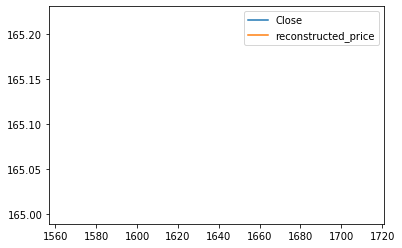

In [104]:
# reconstructing forecasting
df = pd.DataFrame() 
df['Close'] = data[-(forecast_horizon):-(forecast_horizon)+1] # data
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
df['logr_na0'] = forecast[0] 
df['reconstructed_price_norm'] = np.exp(df.logr_na0 * -1) #
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(int)
# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
df.head()

In [105]:
# reconstructing forecasting
reconstructed_price = int(df['Close'].values[0] * np.exp(forecast[0] * -1))
print(f'orig: {data[-(forecast_horizon):-(forecast_horizon)+1].values[0]}   /  rec price: {reconstructed_price}')

orig: 165.22   /  rec price: 165
